In [160]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union, Tuple

## Read and Visualize Correlation Matrix

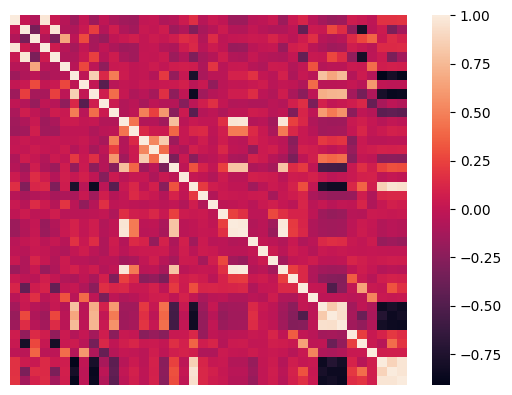

In [206]:
# Read correlation matrix to a numpy array
corr_mat = pd.read_excel('corr_adv.xlsx', index_col=0).values

ax = sns.heatmap(corr_mat, annot=False, xticklabels=False, yticklabels=False)

## Generate Synthetic Data from a Multi-Variate Normal Distribution

In [275]:
def generate_synthetic_data(corr_mat: np.ndarray, 
                            mean: Union[list, np.ndarray] = None,
                            std: Union[list, np.ndarray] = None,
                            size: int = 300) -> np.ndarray:
    
    """A function that generates synthetic data from a multi-variate nromal distribution 
    given a correlation matrix.
    
    The function generates data whose variables are correlated according to a given correlation matrix. 
    
    The function first converts the correlation matrix to a covariance matrix given the std of each 
    variable as input. If std is None, the std is then equal to an identity matrix and the generated
    covariance matrix is equal to the correlation matrix. 
    
    The covariance matrix is then used to randomly sample data from a multi-variate normal distribution. 
    The means of the distribution is given by mean. If None, then a mean of zero is used for each of the
    variables.
    
    Args:
        corr_mat: a positive semidefinite correlation matrix. 
        mean: desired means of the variables. 
        std: desired variances of the variables.
        size: number of samples to draw from the normal distribution.
        
    Returns: sampled data with shape (size, corr_mat.shape[0])
    
    """
    
    # Assert the input correlation matrix is positive semidefinite
    assert np.all(np.linalg.eigvals(corr_mat) > 0), "Correlation matrix must be positive semidefinite"
    
    # Number of variables
    num_vars = corr_mat.shape[0]
    
    if mean is not None:
        assert len(mean) == num_vars, f"mean has {len(mean)} values, it must have {num_vars}"
        
    if std is not None:
        assert len(std) == num_vars, f"std has {len(std)} values, it must have {num_vars}"

    
    # Assign mean=0 & std=1 if they are given as None, convert std to a diagonal matrix
    mean = np.zeros(num_vars) if mean is None else mean
    std = np.identity(num_vars) if std is None else np.diag(std) 
        
    # Convert correlation to covariance (scale with desired range of values)
    cov = std.dot(corr_mat).dot(std)
        
    # Sample data from a normal distribution
    data = np.random.default_rng().multivariate_normal(mean=mean, cov=cov, size=size)
        
    return data


# Generate synthetic data given the correlation matrix from "corr_adv.xlsx"
data = generate_synthetic_data(corr_mat, mean=np.linspace(0, 10, 40), std=np.linspace(0, 1, 40), size=300)

print(f'Shape of the generated data is: {data.shape}')

Shape of the generated data is: (300, 40)


## Comapre Correlation Matrices

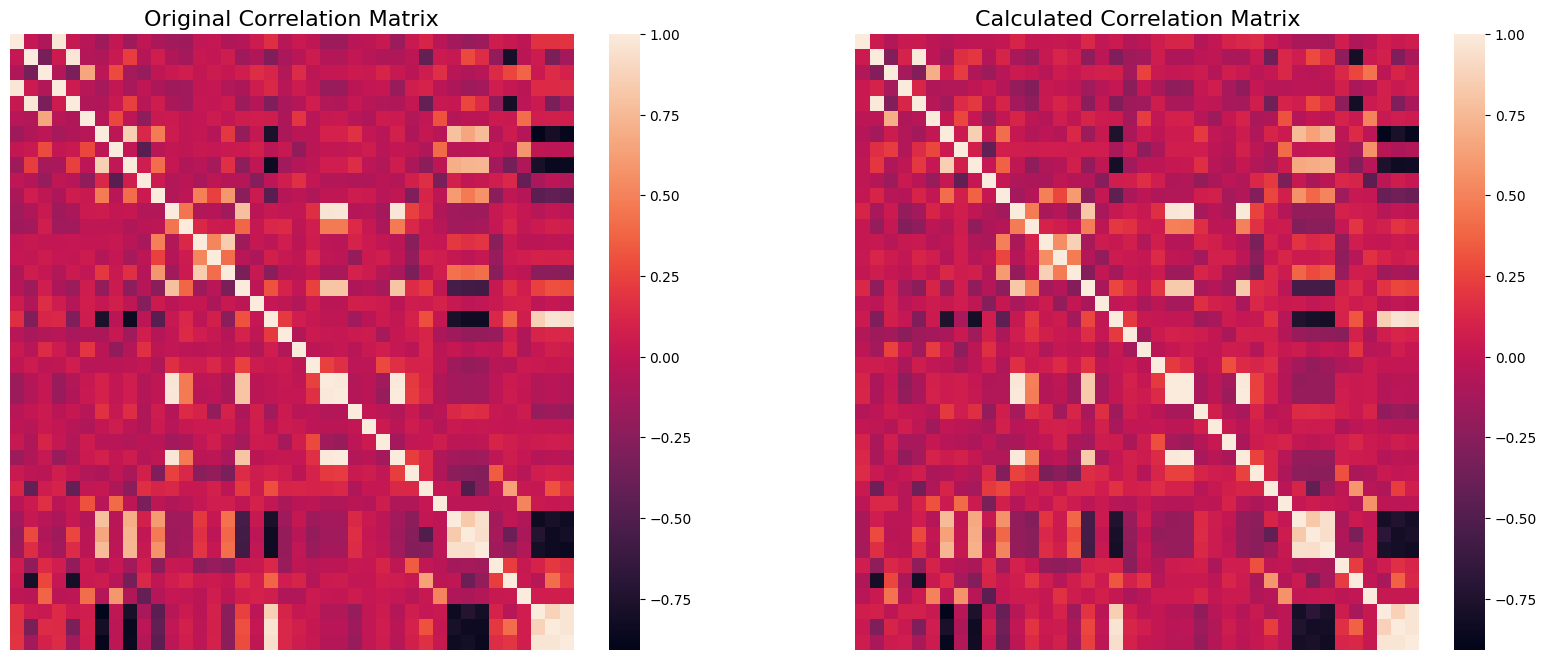

In [276]:
# Visualize the original correlation matrix vs. the calculate correlation matrix of the synthetic data

# Calculated correlation matrix
data_corr_mat = np.corrcoef(data, rowvar=False)

# Visualize both correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Heatmaps
sns.heatmap(corr_mat, ax=axs[0], xticklabels=False, yticklabels=False)
sns.heatmap(data_corr_mat, ax=axs[1], xticklabels=False, yticklabels=False)

# Titles
_ = axs[0].set_title('Original Correlation Matrix', fontsize=16)
_ = axs[1].set_title('Calculated Correlation Matrix', fontsize=16)

In [332]:
def corr_similarity(corr_mat1: np.ndarray,
                    corr_mat2: np.ndarray, 
                    n_iter: int = 10000) -> Tuple[float, float, np.ndarray]:
    
    """A function that tests the similarity of two given correlation matrices
    
    The similarity is calculated using the Frobenius norm of the element-wise differences of the two matrices.
    The function also calculates the p-value of the calculated metric using permutation testing. 
    
    Args:
        corr_mat1: correlation matrix number 1
        corr_mat2: correlation matrix number 2
    
    Returns: the Frobenius norm of the element-wise differences, the p-value, and the norms resulting from 
    permutations
    
    
    References: "Towards Data Science, How to measure similarity between two correlation matrices, Jin"
    
    """

    # Assert both matrices have the same shape 
    assert corr_mat1.shape == corr_mat2.shape, "Both correlation matrices must have the same shape"
    
    # Frobenius norm of element-wise differences matrix
    f_norm = np.linalg.norm(corr_mat2 - corr_mat1)
    
    # Variable indices 
    var_idx = np.arange(corr_mat2.shape[0])

    # List to hold f_norm of the permutation test
    f_norm_permute = []
    
    for i in range(n_iter):
        
        # Shuffle indices
        var_idx = np.random.default_rng().permutation(var_idx)
        
        # Calculate f_norm of corr_mat1 with shuffled corr_mat2
        f_norm_permute.append(np.linalg.norm(corr_mat2[np.ix_(var_idx, var_idx)] - corr_mat1))
                
    # Calculate p-value
    p_value = (np.sum(f_norm_permute <= f_norm) + 1) / (n_iter + 1)

    return f_norm, p_value, np.array(f_norm_permute)


# Calculate similarity
f_norm, p_value, f_norm_permute = corr_similarity(corr_mat, data_corr_mat)

print(f'Similarity between the two correlation matrices is: {f_norm:.2f} with p_value: {p_value:.1e}')

Similarity between the two correlation matrices is: 2.58 with p_value: 1.0e-04


The correlation similarity test shows that the similarity calculated between the original correlation matrix and the calculated correlation of the sampled data is significant because the p-value is much smaller than 0.05